# Q-Learning: Continuous Example with CartPole

This notebook implements the Q-Learning algorithm for the [CartPole](https://gym.openai.com/envs/CartPole-v1/) game.
See `../ReinforcementLearning_Guide.md` for theory and intuition.

According to the OpenAI environment page of CartPole: "A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force to the left (0) or right (1) of the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright (i.e., does not fall). The episode ends when the pole is more than 12 degrees from vertical, or the cart moves more than 2.4 units from the center."

Note that I needed to change the description above, since it is outdated on the web page.

Look at the Github page of the environment, on the docstring of the environment.

Note the following:
- The center position is 0 and the range of possibles postions is `[-2.4,2.4]`, continuous
- Pole angle can vary in `[-12,12] deg`
- Velocity (linear for cart, angular for pole) can be any
- An episode is done if
    1. The pole tresspasses the limits above
    2. 200 steps/actions taken
    3. A minimum return is achieved over 100 steps/actions

We need to discretize the domains using bins.
The unique difference in the Q-Learning process compared to a discrete environemnt (as in FrozenLake) is the mapping from the continuous domain to the discrete.

Overview of sections:

1. Basic Setup of CartPole
2. Q Table Discretization
3. Functions and Hyperparameters
4. Training
5. Utilization of the Learned Q Table

## 1. Basic Setup of CartPole

In [1]:
import time
import gym
import matplotlib.pyplot as plt

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [8]:
%matplotlib notebook

env = gym.make("CartPole-v1")
env.reset()

for step in range(100):
    env.render()
    action = env.action_space.sample() # 0 or 1
    # 4 observations done each step:
    # cart position, cart velocity, pole angle, pole angular velocity
    observation,reward,done,info = env.step(action)
    print(f'Observation: {observation}')
    time.sleep(0.02)
    if done:
        break
env.close()

2022-01-13 12:32:16.227 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd35f89ae20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:32:16.227 python[91016:2954731] Warning: Expected min height of view: (<NSButton: 0x7fd3a81494b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:32:16.228 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd3a8149c40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:32:16.229 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd3a8142b90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation: [ 0.01955238 -0.22954053  0.02286752  0.26312542]
Observation: [ 0.01496157 -0.03475232  0.02813003 -0.02225803]
Observation: [ 0.01426652  0.15995516  0.02768487 -0.30593458]
Observation: [ 0.01746563  0.3546719   0.02156617 -0.5897594 ]
Observation: [ 0.02455907  0.1592547   0.00977099 -0.29036185]
Observation: [ 0.02774416 -0.0360052   0.00396375  0.00538665]
Observation: [ 0.02702405  0.15905967  0.00407148 -0.28604305]
Observation: [ 0.03020525  0.35412332 -0.00164938 -0.57743907]
Observation: [ 0.03728772  0.15902454 -0.01319816 -0.2852762 ]
Observation: [ 0.0404682  -0.03590672 -0.01890368  0.00321507]
Observation: [ 0.03975007 -0.23075254 -0.01883938  0.28987423]
Observation: [ 0.03513502 -0.03536708 -0.0130419  -0.0086904 ]
Observation: [ 0.03442768  0.15993945 -0.01321571 -0.3054595 ]
Observation: [ 0.03762647 -0.0349917  -0.0193249  -0.01697361]
Observation: [ 0.03692663 -0.22983125 -0.01966437  0.26955   ]
Observation: [ 0.03233001 -0.42466715 -0.01427337  0.55

In [7]:
# We can also play it manually
action = 0
k = 0
def key_press(k, mod):
    '''
    This function gets the key press for gym
    '''
    global action
    if k == key.LEFT:
        action = 0
    if k == key.RIGHT:
        action = 1

env.reset()
rewards = 0
for _ in range(1000):
    env.render()
    env.viewer.window.on_key_press = key_press  # update the key press
    observation, reward, done, info = env.step(action)  # get the reward and the done flag
    rewards+=1
    if done:
        print(f"You got {rewards} points!")
        break
    time.sleep(0.5)  # reduce speed a little bit (edit as needed on you computer)
env.close()

2022-01-13 12:29:17.697 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd3a8091420>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:29:17.697 python[91016:2954731] Warning: Expected min height of view: (<NSButton: 0x7fd3a809b220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:29:17.699 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd3a809b9b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-13 12:29:17.700 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd3a809c730>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


You got 8 points!


## 2. Q Table Discretization

In the FrozenLake environment we had one observation which mapped to a unique state variable. Now, we have 4 observation variables and they map to one state. And recall that the Q-Learning table is `state x action`.

To address that issue, we discretize each observation variable in bins and build from the combinations of those observation-bins all possible discrete states. We can represent that in two forms:
- We build a multidimensional matrix/array: dimensions are `observations + action`. Each observation dimension is discretized/binned in all defined ranges and the action dimension contains all possible actions; then, each combination of `observations + actions` has a Q value. Thus, 4 observation values lead to a dimension of 5 (`observations + action`). Each dimension has the size of the number of bins or the number of actions. Example: `4` observations, each one with `3` bins and additionally `2` actions: `np.zeros((3,3,3,3,2))`. Then, each cell maps to a possible Q value.
- Note that combining `observations` and `bins` we get all the `states`. Thus, we can further develop the structure above to have `3^4` states and `2` actions. However, the multidimensional array is more comfortable

In [14]:
import numpy as np

In [17]:
t = np.zeros((3,3,3,3,2))

### Bins

We create the bin ranges and the functions to get bin indices given continuous values.
Note that I think there are some bugs in the course: indices are not correctly handled, since they start at 1, so the table/bin index 0 is not used? I corrected it, if I'm not misunderstanding it.

In [138]:
# We create ranges/bins for all observations
# The more bins we have, the more accurate the system will be
# but the more it is going to require to learn
def create_bins(num_bins_obs = 10):
    # Note that a bins vector with 6 range values leads to 6-1=5 bins!
    # Therefore, if we want n bins, linspace needs to create n+1 range values
    #n = num_bins_obs
    n = num_bins_obs+1
    bins_cart_pos = np.linspace(-2.4,2.4,n)
    # We can have values in (-inf,inf), but after playing a bit we see values are usually in (-5,5)
    bins_cart_vel = np.linspace(-5,5,n)
    bins_pole_angle = np.linspace(-0.209,0.209,n)
    # We can have values in (-inf,inf), but after playing a bit we see values are usually in (-5,5)
    bins_pole_ang_vel = np.linspace(-5,5,n)
    bins = np.array([bins_cart_pos,
                     bins_cart_vel,
                     bins_pole_angle,
                     bins_pole_ang_vel])
    return bins

In [139]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

In [140]:
BINS

array([[-2.4   , -1.92  , -1.44  , -0.96  , -0.48  ,  0.    ,  0.48  ,
         0.96  ,  1.44  ,  1.92  ,  2.4   ],
       [-5.    , -4.    , -3.    , -2.    , -1.    ,  0.    ,  1.    ,
         2.    ,  3.    ,  4.    ,  5.    ],
       [-0.209 , -0.1672, -0.1254, -0.0836, -0.0418,  0.    ,  0.0418,
         0.0836,  0.1254,  0.1672,  0.209 ],
       [-5.    , -4.    , -3.    , -2.    , -1.    ,  0.    ,  1.    ,
         2.    ,  3.    ,  4.    ,  5.    ]])

In [141]:
BINS.shape

(4, 11)

There is a utility in `numpy` which returns the bin index of a value given the bin ranges: `np.digitize()`. By default, the returned index `i` satisfies `bins[i-1] <= x < bins[i]`:

In [142]:
# Example:
# Array with 6 values has 6-1=5 bins
# [0,2,4,6,8,10]
# i refers to the range closure index
# i = 1: [0,2)
# i = 2: [2,4)
# i = 3: [4,6)
# i = 4: [6,8)
# i = 5: [8,10)
# i = 6: x >= 10
# i = 0: x < 0
v = np.array([0,2,4,6,8,10])

In [143]:
x = 0

In [106]:
np.digitize(x,v)

1

In [144]:
# We create a function that uses that digitize utility
def discretize_observation(observations,bins):
    # bin indices for the observations
    binned_observations = []
    for i,observation in enumerate(observations):
        discretized_observation = np.digitize(observation,bins[i,:])
        # np.discretize() yields indices starting at 1
        # thus, we need to decrease it
        discretized_observation = discretized_observation-1
        # check that we are in range: index in [0,NUM_BINS-1]
        if discretized_observation < 0:
            discretized_observation = 0
        # recall BINS/bins contains n+1 range values, n being the number of bins
        # thus, we substract 2 units
        elif discretized_observation > bins.shape[1]-2:
            discretized_observation = bins.shape[1]-2
        binned_observations.append(discretized_observation)
    return tuple(binned_observations)

In [145]:
observations = env.reset()

In [146]:
observations

array([-0.04018523, -0.03253301,  0.02742602, -0.04937429], dtype=float32)

In [147]:
discretize_observation(observations,BINS)

(4, 4, 5, 4)

In [148]:
# Note that if we exceed the ranges, we get invalid indices
# The (correct/valid) indices refer
observation = np.array([10,10,10,10])

In [149]:
discretize_observation(observation,BINS)

(9, 9, 9, 9)

### Q Table

We create the multidimensional Q Table.

In [150]:
q_table_shape = (NUM_BINS,NUM_BINS,NUM_BINS,NUM_BINS,env.action_space.n)

In [134]:
q_table = np.zeros(q_table_shape)

In [135]:
q_table.shape

(10, 10, 10, 10, 2)

In [137]:
q_table[9,9,9,9]

array([0., 0.])

## 3. Functions and Hyperparameters

We copy & paste the functions we had in the discrete case with the FrozenLake environment.
Small modifications are done just to show it is possible to:
- Have different epsilon decay functions
- Have custom rewards (e.g., we could have given -1 rewards when the agent fell into a hole in the FrozenLake game)
Altogether, we have:
- Same `epsilon_greedy_action_selection()` as before
- Same `compute_next_q_value()` as before
- `reduce_epsilon()`  but with a linear decay
- `fail()`, which updates/punishes our rewards

In [172]:
# Epsilon greedy action selection
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
    random_number = np.random.random()
    # Exploitation: choose action that maximizes Q
    if random_number > epsilon:
        # Grab state action row, with all Q values
        state_row = q_table[discrete_state]
        # Select the action index which has the largest Q value
        action = np.argmax(state_row)
    # Exploration: choose a random action
    else:
        action = env.action_space.sample()
    return action

In [173]:
# Q-Learning update equation
# Q_next = Q_old + ALPHA*Q_error
# Q_error = reward + GAMMA*Q_optimum - Q_old
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
    Q_error = reward + GAMMA*next_optimal_q_value - old_q_value
    Q_next = old_q_value + ALPHA*Q_error
    return Q_next

In [174]:
# Hyperparameters
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [175]:
# Hyperparameters: epsilon (exploration vs exploitation)
EPSILON = 1.0
burn_in = 1
epsilon_end = 10000
#epsilon_reduce = 0.0001
epsilon_reduce = 1.0 / epsilon_end

In [176]:
# Epsilon exponential decay after each episode/epoch
def reduce_epsilon(epsilon,epoch):
    # Exponential decay
    #return min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*epoch)
    # Linear decay with a hard stop at a certain number of epochs
    if burn_in <= epoch <= epsilon_end:
        epsilon -= epsilon_reduce
    return epsilon

In [177]:
# Consider that the CartPole environment gives a +1 reward for each step if game is not terminated
# We can actually punish/modify that reward with any logic we would like
# For instance, punish high angular velocities, etc.
# It makes sense to have these kind of reward modifiers when we start having complex environments
def fail(done,points,reward):
    if done and points < 150:
        reward = -200
    return reward

## 4. Training

We basically copy the traning loop from the FrozenLake environment and modify it to have:
- Discretization of states
- Additional logging

**Note**: The instructor plotted an interactive diagram, but that does not work out-of-the-box in Jupyter Lab, only in Jupyter Notebooks. A solution is to follow what is said in this link:

[https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab](https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab)

Or, alternatively, we ca just use the following magic command and just plot the final diagram:

```
%matplotlib inline
```

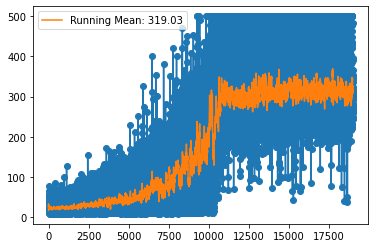

In [183]:
%matplotlib inline
log_interval = 1000
render_interval = 30000 # env.render()
####################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion() # interactive mode on
fig.canvas.draw()
####################################
points_log = []
mean_points_log = []
epochs = []
for epoch in range(EPOCHS):
    initial_state = env.reset()
    # Discretization
    discretized_state = discretize_observation(initial_state,BINS)
    done = False
    points = 0
    epochs.append(epoch)
    # Play the game
    while not done:
        action = epsilon_greedy_action_selection(EPSILON,q_table,discretized_state)
        next_state,reward,done,info = env.step(action)
        # Modify/punish reward
        reward = fail(done,points,reward)
        # Discretization
        next_state_discretized = discretize_observation(next_state,BINS)
        # Tuple concatenation: (o1,o2,o3,o4) + (action,) -> (o1,o2,o3,o4,action)
        old_q_value = q_table[discretized_state + (action,)]
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        q_table[discretized_state + (action,)] = next_q
        discretized_state = next_state_discretized
        points += 1
    EPSILON = reduce_epsilon(EPSILON,epoch)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]),2) # rolling average
    mean_points_log.append(running_mean)
    ####################################
    if epoch % log_interval == 0:
        #print(f"{episode} games played; accumulated reward: {np.sum(rewards)}")
        ax.clear()
        ax.scatter(epochs,points_log)
        ax.plot(epochs,points_log)
        ax.plot(epochs,mean_points_log,label=f'Running Mean: {running_mean}')
        plt.legend()
        fig.canvas.draw()
    ####################################
env.close()

Note that the rolling average is necessary to filter out the noise in the points.
After the hard limit of `10000` we imposed for the linear epsilon decay the points ar flat or changemuch less; we could consider playing with that a bit:
- Modify the hard limit (e.g., increase it)
- Change to exponential decay
- ...

## 5. Utilization of the Learned Q Table

After training has concluded, we can use the `q_table` to take the best action given the state we are in, thus, reaching the goal the fastest possible.

In [189]:
observation = env.reset()
rewards = 0

for steo in range(1000):
    env.render()
    discrete_state = discretize_observation(observation,BINS)
    action = np.argmax(q_table[discrete_state])
    observation,reward,done,info = env.step(action)
    rewards += 1
    if done:
        print(f'Reward points: {rewards}')
        break;
env.close()

2022-01-14 10:14:26.395 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd37fc56fb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-14 10:14:26.395 python[91016:2954731] Warning: Expected min height of view: (<NSButton: 0x7fd37fc5bcc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-14 10:14:26.397 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd37fc5c450>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-01-14 10:14:26.398 python[91016:2954731] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd37fc5d1d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Reward points: 252
